<a href="https://colab.research.google.com/github/erlenman/SOS/blob/master/MLP_with_TF2_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x 
import tensorflow as tf
print(tf.__version__)

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 2.x selected.
2.1.0


In [0]:
plt.rcParams["figure.figsize"] = (12,5)

%tensorflow_version 2.x -- специальная магия Colab, которая переключает версию TensorFlow с 1.х (всё ещё подключенной по умолчанию) в 2.х. Это не заработает в локально выполняемом Jupyter Notebook.


Если вы в Colab, не забудьте подключить GPU в меню: Runtime -> Change runtime type -> Hardware accelerator: GPU.

#Введение в TensorFlow 2.x

## Tensors

Все объекты в TensorFlow являются тензором (многомерной матрицей). Все операции принимают тензор (или несколько) и возвращают тензор.

Самые распространённые типы тензоров -- константный и переменный. Как ясно из названия, значения константного тензора менять нельзя.


Вот [константный](https://www.tensorflow.org/api_docs/python/tf/constant) тензор:

In [3]:
x = tf.constant([[5, 2], [1, 3]])
print(x)

tf.Tensor(
[[5 2]
 [1 3]], shape=(2, 2), dtype=int32)


Его значения можно получить в формате numpy массива, вызвав метод `.numpy()`:

In [4]:
x.numpy()

array([[5, 2],
       [1, 3]], dtype=int32)

Также, как и у массива numpy, у тензора есть тип `dtype` и размерность `shape`:

In [5]:
print('dtype:', x.dtype)
print('shape:', x.shape)

dtype: <dtype: 'int32'>
shape: (2, 2)


Распространённый способ делать константные тензоры это `tf.ones` и `tf.zeros` (такие же, как `np.ones` and `np.zeros`):

In [6]:
print(tf.ones(shape=(2, 2)))
print(tf.zeros(shape=(2, 2)))

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


## Случайные константные тензоры

 [Нормальный](https://www.tensorflow.org/api_docs/python/tf/random/normal) тензор: 

In [7]:
tf.random.normal(shape=(1, 10), mean=0., stddev=1.)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.12154815, -1.7994512 , -0.15696448, -0.13437696, -0.54811835,
        -0.3530583 ,  1.2181131 , -0.06907474, -0.61123854, -0.28616142]],
      dtype=float32)>

Тензор, заполненный [равномерно](https://www.tensorflow.org/api_docs/python/tf/random/uniform) распределёнными целыми числами:

In [8]:
tf.random.uniform(shape=(2, 2), minval=0, maxval=10, dtype='int32')

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[4, 4],
       [3, 5]], dtype=int32)>

## Переменные

[Переменные](https://www.tensorflow.org/guide/variable) это тензоры, которые могут изменяться с помощью специальных операций. Веса нейронных сетей и других моделей будут переменными тензорами. 

При создании переменной ей должно быть присвоено какое-нибудь начальное значение:

In [9]:
initial_value = tf.random.normal(shape=(2, 2))
a = tf.Variable(initial_value)
print(a)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.2140793 , -0.09736868],
       [ 0.13799164, -0.02372594]], dtype=float32)>


Базовый способ изменять значение переменных -- использовать операции присваивания `.assign(value)`, прибавления `.assign_add(increment)` или вычитания `.assign_sub(decrement)`:

In [0]:
new_value = tf.random.normal(shape=(2, 2))
a.assign(new_value)

# check if it's worked
for i in range(2):
  for j in range(2):
    assert a[i, j] == new_value[i, j]

In [0]:
added_value = tf.random.normal(shape=(2, 2))
a.assign_add(added_value)
for i in range(2):
  for j in range(2):
    assert a[i, j] == new_value[i, j] + added_value[i, j]

## Математические расчёты в TensorFlow

Любой рассчёт в TensorFlow -- это вычислительный граф, в узлах которого находятся тензоры или операции над ними. 

Чтобы выполнить расчёт, нужно описать граф вычислений, заполнить его начальными значениями и запустить выполнение.

К счастью, в TensorFlow 2.x (в отличие от предыдущей версии) бОльшая часть этого процесса выполняется автоматически, и зачастую его можно использовать точно так же, как Numpy, делая объявление-присваивание-вычисление в один проход. В большинстве случаев работает простая замена `np.` на `tf.`. 

Основная разница между Numpy и TensorFlow для расчётных задач в том, что код TensorFlow при этом может сразу работать на GPU или TPU.

In [0]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

c = a + b
d = tf.square(c)
e = tf.exp(d)

## Вычисление градиента с `GradientTape`

Другое большое отличие от Numpy: вы можете получить градиент любого выражения в момент его выполнения.

Для этого конкретное выполнение выражения нужно "записать на ленту" с помощью [`GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape). Также необходимо указать, какой тензор вас интересует, используя `.watch()`, и после выполнения ленты, вы сможете узнать, как изменения в этом тензоре влияли на любой другой узел, участвовавший в операции (то есть получить градиент любого узла относительно интересующего):

In [13]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
  tape.watch(a)  # Start recording the history of operations applied to `a`
  c = tf.sqrt(tf.square(a) + tf.square(b))  # Do some math using `a`
  # What's the gradient of `c` with respect to `a`?
  dc_da = tape.gradient(c, a)
  print(dc_da)

tf.Tensor(
[[-0.66302234 -0.882442  ]
 [ 0.00979202 -0.12486047]], shape=(2, 2), dtype=float32)


Вам нужно использовать `watch` только для константных тензоров. Для всех переменных тензоров `watch` включен по умолчанию:

In [14]:
a = tf.Variable(a) # after we made it Variable instead constant

with tf.GradientTape() as tape:
  # we need no watch(a)
  c = tf.sqrt(tf.square(a) + tf.square(b))
  dc_da = tape.gradient(c, a)
  print(dc_da)

tf.Tensor(
[[-0.66302234 -0.882442  ]
 [ 0.00979202 -0.12486047]], shape=(2, 2), dtype=float32)


Обратите внимание, что вы можете вычислять производные высших порядков, используя вложенные ленты:

In [15]:
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as tape:
    c = tf.sqrt(tf.square(a) + tf.square(b))
    dc_da = tape.gradient(c, a)
  d2c_da2 = outer_tape.gradient(dc_da, a) # second order gradient
  print(d2c_da2)

tf.Tensor(
[[0.91381705 0.15168172]
 [2.5583215  0.5744801 ]], shape=(2, 2), dtype=float32)


## Пример от начала до конца: линейная регрессия

Итак, пока что TensorFlow можно воспринимать как замену Numpy с поддержкой параллельных вычислений и автоматическим дифференцированием.

Рассмотрим в качестве базового примера его использования обычную линейную регрессию.

Для честности мы будем использовать только базовые операции.

In [0]:
input_dim = 1 # shape of input sample
output_dim = 1 # shape of prediction
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  return tf.matmul(features, w) + b # matmul is for matrix multiplication

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions)) # tf.reduce_mean is equivalent to np.mean

def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions) 
    # Note that `tape.gradient` works with a list argument as well.
    dloss_dw, dloss_db = tape.gradient(loss, [w, b]) # gradient of loss with respect to weights and biases
  w.assign_sub(learning_rate * dloss_dw) # apply weights correction
  b.assign_sub(learning_rate * dloss_db) # apply biases correction
  return loss # just for print

Создадим простой датасет

In [0]:
mean = [-1, 1] 
cov = [[1, -0.8], 
       [-0.8, 1]] 
size = 10000
sample = np.random.multivariate_normal(mean, cov, size=size).astype(np.float32)

X, y_true = sample[:, 0].reshape((size,1)), sample[:, 1].reshape((size,1))

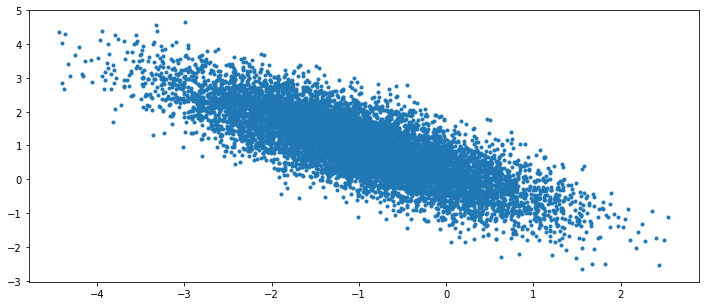

In [18]:
plt.plot(X, y_true, '.')

Разделим датасет на пакеты и обучим модель, многократно выполнив `train_on_batch` на каждом пакете:

In [19]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((X, y_true))
dataset = dataset.shuffle(buffer_size=size).batch(1024)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 2.7049
Epoch 1: last batch loss = 1.3387
Epoch 2: last batch loss = 0.8111
Epoch 3: last batch loss = 0.5504
Epoch 4: last batch loss = 0.4828
Epoch 5: last batch loss = 0.5163
Epoch 6: last batch loss = 0.4542
Epoch 7: last batch loss = 0.4175
Epoch 8: last batch loss = 0.3939
Epoch 9: last batch loss = 0.3946


Результат:

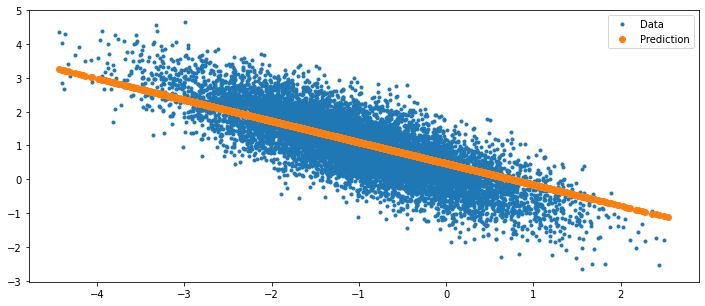

In [20]:
predictions = compute_predictions(X)
plt.plot(X, y_true, '.', label = 'Data')
plt.plot(X, predictions, 'o', label = 'Prediction')
plt.legend()

## Ускорение с помощью `tf.function`

Насколько быстрым является такое обучение?

In [21]:
%%timeit
for step, (x, y) in enumerate(dataset):
  loss = train_on_batch(x, y)

10 loops, best of 3: 36.4 ms per loop


Мы можем значительно ускорить вычисления, скомпилировав функцию в статический граф. В TensorFlow 2.х мы можем оформить почти любую функцию декоратором [tf.function](https://www.tensorflow.org/guide/function), чтобы получить её ускоренную статическую версию:


In [0]:
@tf.function
def train_on_batch(x, y): # no changes in the code of the function
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions) 
    # Note that `tape.gradient` works with a list argument as well.
    dloss_dw, dloss_db = tape.gradient(loss, [w, b]) # gradient of loss with respect weights and biases
  w.assign_sub(learning_rate * dloss_dw) # apply weights correction
  b.assign_sub(learning_rate * dloss_db) # apply biases correction
  return loss # just for print

Попробуем ещё раз:

In [23]:
%%timeit
for step, (x, y) in enumerate(dataset):
  loss = train_on_batch(x, y)

The slowest run took 12.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 21.5 ms per loop


Обычно можно увидеть до 40% ускорения для этой тривиально простой модели; более сложные модели выигрывают больше от компиляции в статический граф.

Общий подход следующий: динамическое выполнение графа ([eager execution](https://www.tensorflow.org/guide/eager)) прекрасно подходит для экспериментов, отладки и других ситуаций, когда удобно обычное построчное вычисление в python-стиле. Но когда приходит время стабилизировать код и масштабироваться, компиляция всего, что можно, в статические графы, даёт значительное преимущество.

## Пример посложнее: нейросеть

Поставим задачу классификации:

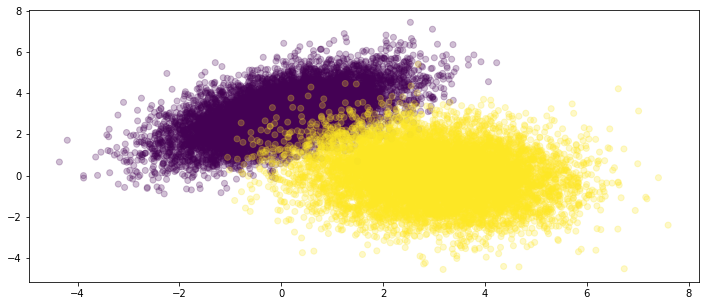

In [24]:
# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1.2, 0.7],[0.7, 1.2]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1.5, -0.2],[-0.2, 1.5]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0], alpha = 0.25)

Основной принцип создания нейросети не отличается от создания линейной регрессии, однако из-за большого количества сущностей внутри модели, управлять ими в "наивном" стиле сложнее.

Попробуем внести некоторую оптимизацию: cохраним веса модели в словари, чтобы можно было обращаться к ним по именам

In [0]:
# Network Parameters
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 16 # 2nd layer number of neurons
input_dim = features.shape[1]
output_dim = labels.shape[1] 

# Store layers weights & biases
weights = {
    'W1': tf.Variable(tf.random.normal([input_dim, n_hidden_1])),
    'W2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, output_dim]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([output_dim]))
}

Мы можем хранить переменные в каких-угодно python-структурах или не хранить вообще: это всё лишь ссылки на объекты TensorFlow, которые существуют независимо от того, как они называются или хранятся на уровне языка.



Создание модели -- это просто описание того, как она превращает входы в выходы:

In [0]:
# Create model
def compute_mlp_predictions(x):
    # Hidden fully connected layer 
    layer_1 = tf.add(tf.matmul(x, weights['W1']), biases['b1'])
    act_1 = tf.nn.sigmoid(layer_1)
    # Hidden fully connected layer 
    layer_2 = tf.add(tf.matmul(act_1, weights['W2']), biases['b2'])
    act_2 = tf.nn.sigmoid(layer_2)
    # Output fully connected layer
    out_layer = tf.matmul(act_2, weights['out']) + biases['out']
    out_act = tf.nn.sigmoid(out_layer)
    return out_act

Зададим Log-loss целевую функцию для решения задачи классификации

In [0]:
def logloss(y, predictions, eps = 1e-5):
  # log-loss is undefined for prediction == 0 or 1, so we are clipping it little bit
  predictions = tf.clip_by_value(predictions, eps, 1 - eps) 
  return tf.reduce_sum(-(y * tf.math.log(predictions) + (1 - y) * tf.math.log(1 - predictions)))

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=len(features)).batch(1024)

In [0]:
from sklearn.metrics import accuracy_score

Вместо того, чтобы вручную обновлять все веса модели, доверим это оптимизатору:

In [30]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = lambda: logloss(y, compute_mlp_predictions(x)) # loss should be callable
    train_op = optimizer.minimize(loss, var_list=[*weights.values(), *biases.values()])
  
  y_predicted = np.where(compute_mlp_predictions(x) > 0.5, 1, 0)
  accuracy = accuracy_score(y, y_predicted)
  print('Epoch %d: last batch loss = %.4f, accuracy = %.3f' % (epoch, loss(), accuracy))


Epoch 0: last batch loss = 42.1622, accuracy = 0.972
Epoch 1: last batch loss = 21.6672, accuracy = 0.985
Epoch 2: last batch loss = 30.2316, accuracy = 0.980
Epoch 3: last batch loss = 28.5679, accuracy = 0.983
Epoch 4: last batch loss = 26.7885, accuracy = 0.982
Epoch 5: last batch loss = 17.9977, accuracy = 0.989
Epoch 6: last batch loss = 16.7341, accuracy = 0.991
Epoch 7: last batch loss = 24.6281, accuracy = 0.985
Epoch 8: last batch loss = 37.8043, accuracy = 0.972
Epoch 9: last batch loss = 25.9778, accuracy = 0.983


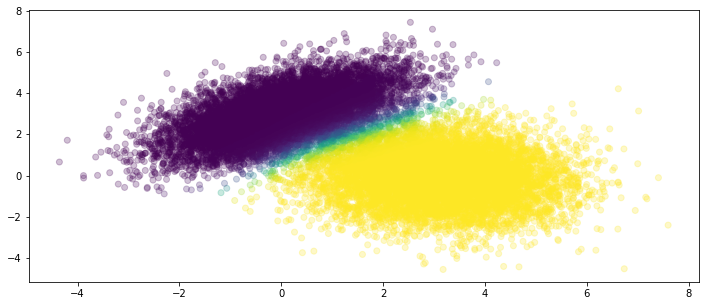

In [31]:
predictions = compute_mlp_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions, alpha = 0.25)

## Задачи Tensorflow:
1. Добавьте ещё один слой нейросети
2. Добавьте L1 регуляризацию в модель, проверьте её эффект
3. Сделайте разделение данных на train и test, нарисуйте кривые обучения

## Пример Keras

Сделаем такую же модель с помощью Keras, as simple as that:

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Keras [поддерживает](https://keras.io/models/about-keras-models/) два основных типа моделей: последовательные (Sequential) и полные (Model). 
В последовательных моделях может быть только один вход и один выход. В полных моделях может быть произвольное число входов и выходов.

In [0]:
model = Sequential()

Последовательные модели задаются простым добавлением слоёв. Первый добавленный слой должен содержать информацию о размерности входного слоя. Последний добавленный слой автоматически становится выходом модели.

In [0]:
# perceptron layer is called Dense in Keras
model.add(Dense(units = n_hidden_1, input_shape=(input_dim,), activation='sigmoid')) 
model.add(Dense(n_hidden_2, activation='sigmoid'))
model.add(Dense(output_dim, activation='sigmoid'))

Окончательно граф модели инициализируется в тот момент, когда задана функция и процедура оптимизации. Для этого в Keras используется команда [compile](https://keras.io/getting-started/sequential-model-guide/#compilation), в которую передаётся [loss](https://keras.io/losses/) функция и алгоритм [оптимизации](https://keras.io/optimizers/). Опционально можно передать и [метрики](https://keras.io/metrics/), которые не будут использоваться для оптимизации, но будут отображаться в процессе обучения.

In [0]:
model.compile(loss = logloss, optimizer=optimizer, metrics = ['accuracy'])

Самые популярные функции можно передать просто по имени.

In [0]:
# model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[logloss]) # using alternative loss as metric for comparison

Наконец, модель обучается в sklearn-стиле, возвращая объект history:

In [37]:
history = model.fit(dataset, epochs=10, verbose=1)

Train for 20 steps
Epoch 1/10
20/20 [==============================] - 0s 10ms/step - loss: 784.5375 - accuracy: 0.7448
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: 96.7822 - accuracy: 0.9803
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 64.0469 - accuracy: 0.9812
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 59.5497 - accuracy: 0.9814
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 58.7992 - accuracy: 0.9806
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 56.7274 - accuracy: 0.9812
Epoch 7/10
20/20 [==============================] - 0s 4ms/step - loss: 56.2603 - accuracy: 0.9813
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 56.1615 - accuracy: 0.9814
Epoch 9/10
20/20 [==============================] - 0s 5ms/step - loss: 55.2047 - accuracy: 0.9811
Epoch 10/10
20/20 [==============================] - 0s 4ms/step - loss: 55.4444 - accur

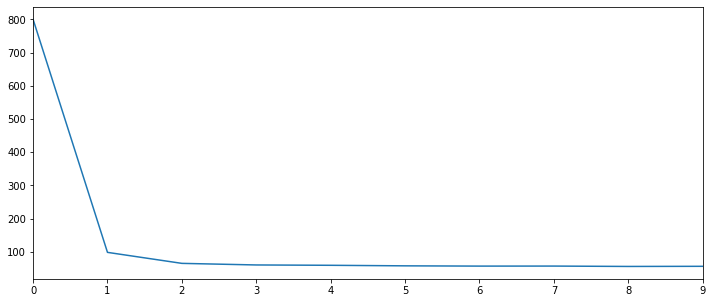

In [43]:
import pandas as pd
pd.DataFrame(history.history)['loss'].plot()

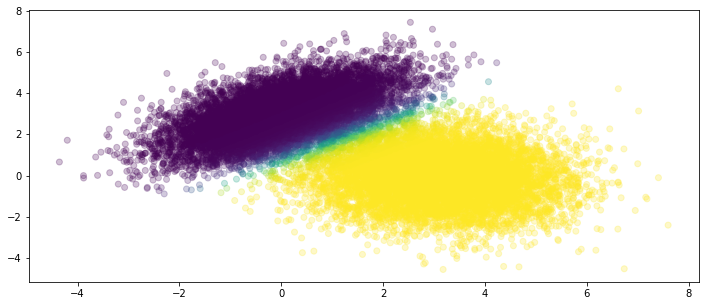

In [39]:
predictions = model.predict(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions, alpha = 0.25)

## Задачи Keras
1. Модифицируйте модель Keras, так, чтобы она решала задачу регрессии. Проверьте решение на датасете из предыдущего домашнего задания.
2. Используйте кросс-валидацию sklearn, чтобы подобрать оптимальное количество нейронов и слоёв модели.